In [1]:
import os
import numpy as np
import time
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [111]:
from keras.datasets import mnist

# load and normalize data
#(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


X_train = tf.reshape(X_train, (X_train.shape[0],-1))/255
X_test = tf.reshape(X_test, (X_test.shape[0],-1))/255

#reserve the last 10000 training examples for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

print("train_size:", X_train.shape)
print("val_size:", X_val.shape)
print("test_size:", X_test.shape)
print("train_output_size", y_train.shape)
print("val_output_size:", y_val.shape)
print("test_output_size", y_test.shape)

size_input = X_train.shape[1]
size_output = len(set(y_train))
size_hidden1 = 256
size_hidden2 = 128

4431872/4422102 [==============================] - 0s 0us/step
train_size: (50000, 784)
val_size: (10000, 784)
test_size: (10000, 784)
train_output_size (50000,)
val_output_size: (10000,)
test_output_size (10000,)


In [112]:
# Define class to build mlp model
class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_output, device=None,\
                 regularizer=None, R_lambda = 1e-4, drop_prob=0):
        """
        size_input: int, size of input layer
        size_hidden: int, size of hidden layer
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        regularizer: str or None
        R_lambda: the parameter for regularizer
        drop_prob: 0 to 1
        """
        self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.device =\
        size_input, size_hidden1, size_hidden2, size_output, device
        
        self.regularizer, self.R_lambda, self.drop_prob = regularizer, R_lambda, drop_prob
        
        # Initialize weights between input layer and hidden layer 1
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
        # Initialize biases for hidden layer 1
        self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))

        # Initialize weights between hidden layer 1 and hidden layer 2
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
        # Initialize biases for hidden layer 2
        self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))

         # Initialize weights between hidden layer 2 and output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
        # Initialize biases for output layer
        self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

        # Define variables to be updated during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
        
        # Initialize the state of Adam-yogi algorithm
        self.v_W1 = tf.Variable(tf.zeros([self.size_input, self.size_hidden1]))
        self.v_b1 = tf.Variable(tf.zeros([1,self.size_hidden1]))
        self.s_W1 = tf.Variable(tf.zeros([self.size_input, self.size_hidden1]))
        self.s_b1 = tf.Variable(tf.zeros([1,self.size_hidden1]))
        
        self.v_W2 = tf.Variable(tf.zeros([self.size_hidden1, self.size_hidden2]))
        self.v_b2 = tf.Variable(tf.zeros([1,self.size_hidden2]))
        self.s_W2 = tf.Variable(tf.zeros([self.size_hidden1, self.size_hidden2]))
        self.s_b2 = tf.Variable(tf.zeros([1,self.size_hidden2]))
        
        self.v_W3 = tf.Variable(tf.zeros([self.size_hidden2, self.size_output]))
        self.v_b3 = tf.Variable(tf.zeros([1,self.size_output]))
        self.s_W3 = tf.Variable(tf.zeros([self.size_hidden2, self.size_output]))
        self.s_b3 = tf.Variable(tf.zeros([1,self.size_output]))
        
        self.v_state = [self.v_W1,self.v_W2,self.v_W3,self.v_b1,self.v_b2,self.v_b3]
        self.s_state = [self.s_W1,self.s_W2,self.s_W3,self.s_b1,self.s_b2,self.s_b3]
         
    def forward(self, X):
        """
        forward pass
        X: Tensor, inputs
        """
        def compute_output(X):
            # Cast X to float32
            X_tf = tf.cast(X, dtype=tf.float32)
            
            #set the dropout prob
            prob = self.drop_prob

            # Remember to normalize your dataset before moving forward
            # Compute values in hidden layer 1
            what1 = tf.matmul(X_tf, self.W1) + self.b1
            hhat1 = tf.nn.experimental.stateless_dropout(tf.nn.sigmoid(what1), rate = prob, seed = [1,0])

            # Compute values in hidden layer 2
            what2 = tf.matmul(hhat1, self.W2) + self.b2
            hhat2 = tf.nn.experimental.stateless_dropout(tf.nn.sigmoid(what2), rate = prob, seed = [1,0])

            # Compute output
            output = tf.nn.softmax(tf.matmul(hhat2, self.W3) + self.b3)

            return output
        
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = compute_output(X)
        else:
            self.y = compute_output(X)

        return self.y
    
    def loss(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''  
        #cross entropy loss for classifation mission
        return tf.losses.sparse_categorical_crossentropy(y_true,y_pred, from_logits = False)
        #return tf.reduce_sum(-tf.math.log(tf.boolean_mask(y_pred, tf.one_hot(y_true, depth=y_pred.shape[-1]))))/y_pred.shape[0]
        
    def backward(self, X_train, y_train, hyperparams):
        """
        backward pass
        """
        #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
            
            num_layer = 3
            if not self.regularizer:
                current_loss = self.loss(predicted, y_train)
            elif self.regularizer == 'l2':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l2_loss(w)
            elif self.regularizer == 'l1':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l1_loss(w)
            
        grads = tape.gradient(current_loss, self.variables)

        #use adam optimizer
        '''
        adam optimizer
        '''
        beta1, beta2, eps = 0.9, 0.999, 1e-6

        for p, v, s, grad in zip(self.variables, self.v_state, self.s_state, grads):
            v[:].assign(beta1 * v  + (1 - beta1) * grad)
            s[:].assign(s + (1 - beta2) * tf.math.sign(tf.math.square(grad) - s) * tf.math.square(grad))
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:].assign(p - hyperparams['lr'] * v_bias_corr/ (tf.math.sqrt(s_bias_corr) + eps))
            

    def accuracy(self,y_pred, y_true):
        """
        compute the correct num
        y_pred: the probability distribution [[...]] or the predicted label [...]
        y_true: the 1-D true label
        """
        #detect if y_pred is a probability distribution 
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = tf.argmax(y_pred, axis=1)
            
        cmp = tf.cast(y_pred, y_true.dtype) == y_true
        
        return float(tf.reduce_sum(tf.cast(cmp, tf.int32)))
    
#     def dropout_layer(self,X, dropout):
#         assert 0 <= dropout <= 1
#         # In this case, all elements are dropped out
#         if dropout == 1:
#             return tf.zeros_like(X)
#         # In this case, all elements are kept
#         if dropout == 0:
#             return X
#         mask = tf.random.uniform(
#             shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
#         return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)


# Train Model

In [ ]:
#save the model for tuning
import pickle
def save_object(obj, filename):
    # Overwrites any existing file.
    with open(filename, 'wb') as file:  
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    # Open the file in binary mode
    with open(filename, 'rb') as file:  
        # Call load method to deserialze
        return pickle.load(file)

# Set number of simulations and epochs
NUM_SIM = 10
NUM_EPOCHS = 200

#set the train_record
train_loss_record = [[] for _ in range(NUM_SIM)]
train_acc_record = [[] for _ in range(NUM_SIM)]
val_loss_record = [[] for _ in range(NUM_SIM)]
val_acc_record = [[] for _ in range(NUM_SIM)]
test_loss_record = [[] for _ in range(NUM_SIM)]
test_acc_record = [[] for _ in range(NUM_SIM)]

for num_sim in range(NUM_SIM):
    np.random.seed(num_sim)
    tf.random.set_seed(num_sim)
    '''
    Initialize model using GPU or load an exitsing MLP
    '''
    mlp_DIY = MLP(size_input, size_hidden1, size_hidden2, size_output, device='GPU',\
                 regularizer='l2', R_lambda = 1e-4, drop_prob=0.)
    #mlp_DIY = load_object('mlp_DIY.pkl')

    time_start = time.time()
    hyperparams = {'t':1.0, 'lr':1e-4}

    for epoch in range(NUM_EPOCHS):
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*num_sim).batch(128)

        for inputs, outputs in train_ds:
            preds = mlp_DIY.forward(inputs)

            #use adam to train the model
            mlp_DIY.backward(inputs, outputs, hyperparams)
            hyperparams['t'] += 1
        
        if (epoch + 1)%10 == 0:
            #compute the result for the current epoch
            logits = mlp_DIY.forward(X_train)
            train_loss = np.sum(mlp_DIY.loss(logits, y_train))/len(y_train)
            train_acc = mlp_DIY.accuracy(logits,y_train)/len(y_train)
            train_loss_record[num_sim].append(train_loss)
            train_acc_record[num_sim].append(train_acc)

            logits = mlp_DIY.forward(X_val)
            val_loss = np.sum(mlp_DIY.loss(logits, y_val))/len(y_val)
            val_acc = mlp_DIY.accuracy(logits,y_val)/len(y_val)
            val_loss_record[num_sim].append(val_loss)
            val_acc_record[num_sim].append(val_acc)
            
            logits = mlp_DIY.forward(X_test)
            test_loss = np.sum(mlp_DIY.loss(logits, y_test))/len(y_test)
            test_acc = mlp_DIY.accuracy(logits,y_test)/len(y_test)
            test_loss_record[num_sim].append(test_loss)
            test_acc_record[num_sim].append(test_acc)
            
            print('Number of Simulation = {} - Number of Epoch = {}'.format(num_sim+1, epoch + 1))
            print('Train loss:= {:.4f} - Val loss: {:.4f} - Test loss: {:.4f} - Train acc:= {:.2%} - Val acc:= {:.2%} - Test acc:= {:.2%}'\
                  .format(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc))
            
    time_taken = time.time() - time_start 
    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#save_object(mlp_DIY,'mlp_DIY_dropout.pkl')

Number of Simulation = 1 - Number of Epoch = 10
Train loss:= 0.7107 - Val loss: 0.7438 - Test loss: 0.7818 - Train acc:= 76.41% - Val acc:= 74.98% - Test acc:= 74.62%
Number of Simulation = 1 - Number of Epoch = 20
Train loss:= 0.5814 - Val loss: 0.6307 - Test loss: 0.6664 - Train acc:= 80.05% - Val acc:= 78.14% - Test acc:= 78.05%

Total time taken (in seconds): 142.04
Number of Simulation = 2 - Number of Epoch = 10
Train loss:= 0.7420 - Val loss: 0.7823 - Test loss: 0.8161 - Train acc:= 75.46% - Val acc:= 73.82% - Test acc:= 73.61%


the final average result: test loss := 0.5787 - test acc := 82.95% - the std of test acc := 0.0388


<Figure size 432x288 with 0 Axes>

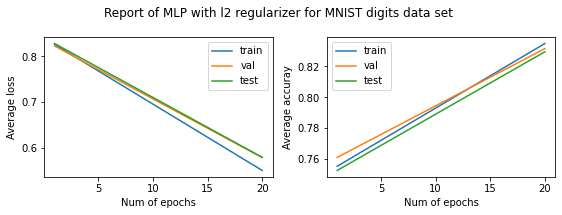

In [108]:
import matplotlib.pyplot as plt
train_average_loss = np.mean(train_loss_record,0)
train_average_acc = np.mean(train_acc_record,0)
val_average_loss = np.mean(val_loss_record,0)
val_average_acc = np.mean(val_acc_record,0)
test_average_loss = np.mean(test_loss_record,0)
test_average_acc = np.mean(test_acc_record,0)

test_var_acc = np.var(test_acc_record,1)[-1]
x = np.linspace(1,NUM_EPOCHS,len(train_average_loss))

plt.figure()
f, ax = plt.subplots(1,2, sharex = True, sharey = False,figsize=(8,3))
f.suptitle('Report of MLP with l2 regularizer for MNIST digits data set')


ax[0].plot(x,train_average_loss,label='train')
ax[0].plot(x,val_average_loss,label='val')
ax[0].plot(x,test_average_loss,label='test')
ax[0].set_title('')
ax.flat[0].set(xlabel='Num of epochs', ylabel='Average loss')
ax[0].legend()


ax[1].plot(x,train_average_acc,label='train')
ax[1].plot(x,val_average_acc,label='val')
ax[1].plot(x,test_average_acc,label='test')
ax[1].set_title('')
ax.flat[1].set(xlabel='Num of epochs', ylabel='Average accuray')
ax[1].legend()

print('the final average result: test loss := {:.4f} - test acc := {:.2%} - the std of test acc := {:.4f}'
      .format(test_average_loss[-1], test_average_acc[-1], np.sqrt(test_var_acc)))
f.tight_layout()
plt.show()